<a href="https://colab.research.google.com/github/deepukesr/IntershipMainAssignment/blob/main/olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Install required packages**

In [2]:
# Install required packages
!pip install apache-airflow pandas matplotlib seaborn SQLAlchemy kaggle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.4/548.4 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━

**Step 2: Configure Kaggle API - Download Dataset**

In [3]:
# Configure Kaggle API
!mkdir -p ~/.kaggle
!echo '{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_API_KEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d olistbr/brazilian-ecommerce
!unzip brazilian-ecommerce.zip -d data/


Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
Archive:  brazilian-ecommerce.zip
  inflating: data/olist_customers_dataset.csv  
  inflating: data/olist_geolocation_dataset.csv  
  inflating: data/olist_order_items_dataset.csv  
  inflating: data/olist_order_payments_dataset.csv  
  inflating: data/olist_order_reviews_dataset.csv  
  inflating: data/olist_orders_dataset.csv  
  inflating: data/olist_products_dataset.csv  
  inflating: data/olist_sellers_dataset.csv  
  inflating: data/product_category_name_translation.csv  


**Step 3: Database Connectivity Established**

In [4]:
import sqlite3
from sqlite3 import Error

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(f"SQLite version: {sqlite3.version}")
        return conn
    except Error as e:
        print(e)

    return conn

# Create a database connection
conn = create_connection("ecommerce.db")

SQLite version: 2.6.0


In [5]:
import os
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python_operator import PythonOperator

# Set Airflow's home directory
os.environ['AIRFLOW_HOME'] = '/content/airflow'

# Initialize the Airflow database
!airflow db init


<ipython-input-5-ed6e52073e41>:4 DeprecationWarning: The `airflow.operators.python_operator.PythonOperator` class is deprecated. Please use `'airflow.operators.python.PythonOperator'`.

DB: sqlite:////content/airflow/airflow.db
[2025-04-02T18:57:59.656+0000] {migration.py:207} INFO - Context impl SQLiteImpl.
[2025-04-02T18:57:59.657+0000] {migration.py:210} INFO - Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running stamp_revision  -> 5f2621c13b39
WARNI [airflow.models.crypto] empty cryptography key - values will not be stored encrypted.
Initialization done


**Step 4: Airflow Server Established, Initialize DAG To Create ETL Pipeline**

In [6]:
import pandas as pd
import glob
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def extract_data():
    """
    Extract data from CSV files in the data directory
    """
    logger.info("Starting data extraction")
    csv_files = glob.glob('/content/data/*.csv')
    dataframes = {}

    try:
        for file in csv_files:
            file_name = os.path.basename(file).split('.')[0]
            df = pd.read_csv(file)
            dataframes[file_name] = df
            logger.info(f"Extracted {file_name} with {len(df)} rows")
    except Exception as e:
        logger.error(f"Error extracting data: {e}")
        raise

    logger.info("Data extraction completed successfully")
    return dataframes

def load_to_database(**context):
    """
    Load dataframes into SQLite database
    """
    logger.info("Starting data loading to database")
    conn = create_connection("ecommerce.db")

    try:
        dataframes = context['ti'].xcom_pull(task_ids='extract_data')
        for table_name, df in dataframes.items():
            # Clean table name
            table_name = table_name.replace('-', '_')
            # Write dataframe to SQL
            df.to_sql(table_name, conn, if_exists='replace', index=False)
            logger.info(f"Loaded {len(df)} rows into table {table_name}")
    except Exception as e:
        logger.error(f"Error loading data to database: {e}")
        raise
    finally:
        if conn:
            conn.close()

    logger.info("Data loading completed successfully")

# Define the DAG
default_args = {
    'owner': 'data_engineer',
    'depends_on_past': False,
    'start_date': datetime(2023, 1, 1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}

data_acquisition_dag = DAG(
    'data_acquisition_dag',
    default_args=default_args,
    description='ETL DAG for data acquisition',
    schedule_interval=timedelta(days=1),
)

extract_task = PythonOperator(
    task_id='extract_data',
    python_callable=extract_data,
    dag=data_acquisition_dag,
)

load_task = PythonOperator(
    task_id='load_to_database',
    python_callable=load_to_database,
    provide_context=True,
    dag=data_acquisition_dag,
)

extract_task >> load_task

[2025-04-02T19:02:42.063+0000] {utils.py:162} INFO - NumExpr defaulting to 2 threads.


<ipython-input-6-e1726cecb84b>:66 RemovedInAirflow3Warning: Param `schedule_interval` is deprecated and will be removed in a future release. Please use `schedule` instead.

<ipython-input-6-e1726cecb84b>:79 RemovedInAirflow3Warning: provide_context is deprecated as of 2.0 and is no longer required

<Task(PythonOperator): load_to_database>

**Step 5: Created KPIs**

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import base64

def calculate_kpis():
    """
    Calculate business KPIs from database
    """
    logger.info("Starting KPI calculation")
    conn = create_connection("ecommerce.db")
    kpi_results = {}

    try:
        # KPI 1: Sales by region
        query_sales_by_region = """
        SELECT
            c.customer_state,
            COUNT(o.order_id) as num_orders,
            SUM(p.payment_value) as total_sales
        FROM
            olist_orders_dataset o
        JOIN
            olist_customers_dataset c ON o.customer_id = c.customer_id
        JOIN
            olist_order_payments_dataset p ON o.order_id = p.order_id
        WHERE
            o.order_status = 'delivered'
        GROUP BY
            c.customer_state
        ORDER BY
            total_sales DESC
        """
        sales_by_region = pd.read_sql(query_sales_by_region, conn)

         # Save to CSV
        sales_by_region.to_csv(r"/content/data/sales_by_region.csv", index=False)
        print("CSV file saved successfully as 'sales_by_region.csv'.")

        kpi_results['sales_by_region'] = sales_by_region

        # KPI 2: Customer lifetime value (CLV)
        query_clv = """
        SELECT
            c.customer_unique_id,
            COUNT(DISTINCT o.order_id) as num_orders,
            SUM(p.payment_value) as total_spent,
            SUM(p.payment_value) / COUNT(DISTINCT o.order_id) as avg_order_value
        FROM
            olist_customers_dataset c
        JOIN
            olist_orders_dataset o ON c.customer_id = o.customer_id
        JOIN
            olist_order_payments_dataset p ON o.order_id = p.order_id
        WHERE
            o.order_status = 'delivered'
        GROUP BY
            c.customer_unique_id
        """
        clv_data = pd.read_sql(query_clv, conn)

        # Save to CSV
        sales_by_region.to_csv(r"/content/data/CLV.csv", index=False)

        kpi_results['customer_lifetime_value'] = clv_data

        # KPI 3: Product category performance
        query_category_performance = """
        SELECT
            p.product_category_name,
            COUNT(oi.order_id) as num_orders,
            COUNT(DISTINCT oi.order_id) as unique_orders,
            AVG(oi.price) as avg_price,
            SUM(oi.price) as total_revenue
        FROM
            olist_order_items_dataset oi
        JOIN
            olist_products_dataset p ON oi.product_id = p.product_id
        JOIN
            olist_orders_dataset o ON oi.order_id = o.order_id
        WHERE
            o.order_status = 'delivered'
            AND p.product_category_name IS NOT NULL
        GROUP BY
            p.product_category_name
        ORDER BY
            total_revenue DESC
        """
        category_performance = pd.read_sql(query_category_performance, conn)

        # Save to CSV
        sales_by_region.to_csv(r"/content/data/product_c_p.csv", index=False)

        kpi_results['category_performance'] = category_performance

    except Exception as e:
        logger.error(f"Error calculating KPIs: {e}")
        raise
    finally:
        if conn:
            conn.close()

    logger.info("KPI calculation completed successfully")
    return kpi_results


**Step 5.1 Storing KPIs Result**

In [29]:
def store_kpi_results(**context):
    """
    Store KPI results in database
    """
    logger.info("Starting to store KPI results")
    conn = create_connection("ecommerce.db")

    try:
        kpi_results = context['ti'].xcom_pull(task_ids='calculate_kpis')
        for kpi_name, kpi_df in kpi_results.items():
            # Store KPI results
            kpi_df.to_sql(f"kpi_{kpi_name}", conn, if_exists='replace', index=False)
            logger.info(f"Stored KPI results for {kpi_name}")
    except Exception as e:
        logger.error(f"Error storing KPI results: {e}")
        raise
    finally:
        if conn:
            conn.close()

    logger.info("KPI storage completed successfully")
    return kpi_results

**Step 5.2: Functions for Graphical Representaton for KPIs**

In [30]:
def generate_visualizations(**context):
    """
    Generate visualizations for each KPI
    """
    logger.info("Starting visualization generation")
    kpi_results = context['ti'].xcom_pull(task_ids='store_kpi_results')
    visualizations = {}

    try:
        # Visualization for Sales by Region
        plt.figure(figsize=(12, 8))
        top_10_regions = kpi_results['sales_by_region'].sort_values('total_sales', ascending=False).head(10)
        sns.barplot(x='total_sales', y='customer_state', data=top_10_regions)
        plt.title('Total Sales by Region (Top 10)')
        plt.tight_layout()

        # Save the plot to a BytesIO object
        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        image_png = buffer.getvalue()
        buffer.close()

        # Encode the image to base64
        graphic = base64.b64encode(image_png).decode('utf-8')
        visualizations['sales_by_region'] = graphic
        plt.close()

        # Visualization for Customer Lifetime Value
        plt.figure(figsize=(10, 6))
        sns.histplot(kpi_results['customer_lifetime_value']['total_spent'], bins=30)
        plt.title('Distribution of Customer Lifetime Value')
        plt.xlabel('Total Spent (BRL)')
        plt.tight_layout()

        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        image_png = buffer.getvalue()
        buffer.close()

        graphic = base64.b64encode(image_png).decode('utf-8')
        visualizations['customer_lifetime_value'] = graphic
        plt.close()

        # Visualization for Category Performance
        plt.figure(figsize=(14, 10))
        top_categories = kpi_results['category_performance'].sort_values('total_revenue', ascending=False).head(15)
        sns.barplot(x='total_revenue', y='product_category_name', data=top_categories)
        plt.title('Revenue by Product Category (Top 15)')
        plt.tight_layout()

        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        image_png = buffer.getvalue()
        buffer.close()

        graphic = base64.b64encode(image_png).decode('utf-8')
        visualizations['category_performance'] = graphic
        plt.close()

    except Exception as e:
        logger.error(f"Error generating visualizations: {e}")
        raise

    logger.info("Visualization generation completed successfully")

    # Store visualizations in the database as base64 strings
    conn = create_connection("ecommerce.db")
    try:
        vis_df = pd.DataFrame([
            {'kpi_name': k, 'visualization': v}
            for k, v in visualizations.items()
        ])
        vis_df.to_sql('kpi_visualizations', conn, if_exists='replace', index=False)
    finally:
        if conn:
            conn.close()

    return visualizations

# Define the KPI DAG
kpi_dag = DAG(
    'kpi_calculation_dag',
    default_args=default_args,
    description='ETL DAG for KPI calculation',
    schedule_interval=timedelta(days=1),
)

calculate_kpis_task = PythonOperator(
    task_id='calculate_kpis',
    python_callable=calculate_kpis,
    dag=kpi_dag,
)

store_kpi_task = PythonOperator(
    task_id='store_kpi_results',
    python_callable=store_kpi_results,
    provide_context=True,
    dag=kpi_dag,
)

visualize_task = PythonOperator(
    task_id='generate_visualizations',
    python_callable=generate_visualizations,
    provide_context=True,
    dag=kpi_dag,
)

calculate_kpis_task >> store_kpi_task >> visualize_task

<ipython-input-30-0b1afa9c8fda>:84 RemovedInAirflow3Warning: Param `schedule_interval` is deprecated and will be removed in a future release. Please use `schedule` instead.

<ipython-input-30-0b1afa9c8fda>:97 RemovedInAirflow3Warning: provide_context is deprecated as of 2.0 and is no longer required

<ipython-input-30-0b1afa9c8fda>:104 RemovedInAirflow3Warning: provide_context is deprecated as of 2.0 and is no longer required

<Task(PythonOperator): generate_visualizations>

**Step 6: Running DAG**<br/>
**Data Aquisition**

In [31]:
def run_acquisition_dag():
    """Simulate running the data acquisition DAG"""
    print("Running Data Acquisition DAG...")
    # Extract data
    dataframes = extract_data()

    # Load data to database
    conn = create_connection("ecommerce.db")
    try:
        for table_name, df in dataframes.items():
            # Clean table name
            table_name = table_name.replace('-', '_')
            # Write dataframe to SQL
            df.to_sql(table_name, conn, if_exists='replace', index=False)
            print(f"Loaded {len(df)} rows into table {table_name}")
    finally:
        if conn:
            conn.close()

    print("Data Acquisition DAG completed successfully")

**KPI Calculation DAG**

In [32]:
def run_kpi_dag():
    """Simulate running the KPI calculation DAG"""
    print("Running KPI Calculation DAG...")

    # Calculate KPIs
    kpi_results = calculate_kpis()

    # Store KPI results
    conn = create_connection("ecommerce.db")
    try:
        for kpi_name, kpi_df in kpi_results.items():
            # Store KPI results
            kpi_df.to_sql(f"kpi_{kpi_name}", conn, if_exists='replace', index=False)
            print(f"Stored KPI results for {kpi_name}")
    finally:
        if conn:
            conn.close()

    # Generate visualizations - directly pass kpi_results instead of expecting it from XCom
    visualizations = generate_visualizations(kpi_results=kpi_results)

    print("KPI Calculation DAG completed successfully")

    # Display visualizations
    if visualizations:
        from IPython.display import Image, display
        import base64

        # Display all visualizations
        for viz_name, viz_data in visualizations.items():
            print(f"\nDisplaying {viz_name} visualization:")
            display(Image(data=base64.b64decode(viz_data)))

**Graphical Representation of KPIs**

In [33]:

def generate_visualizations(kpi_results):
    """Generate visualizations for KPI results

    Args:
        kpi_results (dict): Dictionary of KPI dataframes

    Returns:
        dict: Dictionary of base64-encoded visualizations
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import io
    import base64
    import pandas as pd

    # Make sure we have the KPI results
    if not kpi_results:
        print("No KPI results available for visualization")
        return {}

    print("Generating visualizations...")
    visualizations = {}

    # Create visualizations based on the KPI results
    # Sales by region visualization
    if 'sales_by_region' in kpi_results:
        plt.figure(figsize=(10, 6))
        df = kpi_results['sales_by_region']

        # Check column names and print them to debug
        print(f"Sales by region DataFrame columns: {df.columns.tolist()}")

        # Try to find region column (may have different name)
        region_col = None
        sales_col = None

        # Look for region column
        for col in df.columns:
            if 'region' in col.lower() or 'state' in col.lower() or 'area' in col.lower():
                region_col = col
                break

        # Look for sales column
        for col in df.columns:
            if 'sales' in col.lower() or 'revenue' in col.lower() or 'amount' in col.lower():
                sales_col = col
                break

        if region_col and sales_col:
            # Use the detected columns
            sns.barplot(x=region_col, y=sales_col, data=df)
            plt.title(f'{sales_col} by {region_col}')
        else:
            # Fallback to plotting the first two columns
            if len(df.columns) >= 2:
                sns.barplot(x=df.columns[0], y=df.columns[1], data=df)
                plt.title(f'{df.columns[1]} by {df.columns[0]}')
            else:
                # Not enough columns to plot
                print("Not enough columns in sales_by_region dataframe to create visualization")
                plt.text(0.5, 0.5, "Insufficient data for visualization",
                         horizontalalignment='center', verticalalignment='center')

        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save to buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        visualizations['sales_by_region'] = base64.b64encode(buf.read()).decode('utf-8')
        plt.close()

    # Add more visualizations for other KPIs as needed
    if 'category_performance' in kpi_results:
        plt.figure(figsize=(12, 8))
        df = kpi_results['category_performance']

        # Check column names
        print(f"Category performance DataFrame columns: {df.columns.tolist()}")

        # Look for suitable columns
        revenue_col = None
        category_col = None

        # Find revenue column
        for col in df.columns:
            if 'revenue' in col.lower() or 'sales' in col.lower() or 'amount' in col.lower():
                revenue_col = col
                break

        # Find category column
        for col in df.columns:
            if 'category' in col.lower() or 'product' in col.lower() or 'name' in col.lower():
                category_col = col
                break

        if revenue_col and category_col:
            # Sort and plot top 10 categories
            sorted_df = df.sort_values(revenue_col, ascending=False).head(10)
            sns.barplot(x=revenue_col, y=category_col, data=sorted_df)
            plt.title(f'Top 10 Categories by {revenue_col}')
        else:
            # Fallback
            if len(df.columns) >= 2:
                sorted_df = df.sort_values(df.columns[1], ascending=False).head(10)
                sns.barplot(x=df.columns[1], y=df.columns[0], data=sorted_df)
                plt.title(f'Top 10 by {df.columns[1]}')
            else:
                plt.text(0.5, 0.5, "Insufficient data for visualization",
                         horizontalalignment='center', verticalalignment='center')

        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        visualizations['category_performance'] = base64.b64encode(buf.read()).decode('utf-8')
        plt.close()

    # Customer lifetime value visualization
    if 'customer_lifetime_value' in kpi_results:
        plt.figure(figsize=(10, 6))
        df = kpi_results['customer_lifetime_value']

        # Check column names
        print(f"Customer lifetime value DataFrame columns: {df.columns.tolist()}")

        # Look for value column
        value_col = None
        for col in df.columns:
            if 'value' in col.lower() or 'amount' in col.lower() or 'revenue' in col.lower() or 'ltv' in col.lower():
                value_col = col
                break

        if value_col:
            # Plot histogram of customer values
            plt.hist(df[value_col], bins=30)
            plt.title(f'Distribution of {value_col}')
            plt.xlabel(f'{value_col} ($)')
        else:
            # Fallback to the first numeric column
            numeric_cols = df.select_dtypes(include=['number']).columns
            if len(numeric_cols) > 0:
                plt.hist(df[numeric_cols[0]], bins=30)
                plt.title(f'Distribution of {numeric_cols[0]}')
                plt.xlabel(f'{numeric_cols[0]}')
            else:
                plt.text(0.5, 0.5, "No numeric data for visualization",
                         horizontalalignment='center', verticalalignment='center')

        plt.ylabel('Number of Customers')
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        visualizations['customer_lifetime_value'] = base64.b64encode(buf.read()).decode('utf-8')
        plt.close()

    print(f"Generated {len(visualizations)} visualizations")
    return visualizations

**Result**

Running Data Acquisition DAG...
[2025-04-02T19:34:06.023+0000] {<ipython-input-6-e1726cecb84b>:14} INFO - Starting data extraction
[2025-04-02T19:34:06.925+0000] {<ipython-input-6-e1726cecb84b>:23} INFO - Extracted olist_geolocation_dataset with 1000163 rows
[2025-04-02T19:34:06.930+0000] {<ipython-input-6-e1726cecb84b>:23} INFO - Extracted product_category_name_translation with 71 rows
[2025-04-02T19:34:06.977+0000] {<ipython-input-6-e1726cecb84b>:23} INFO - Extracted olist_products_dataset with 32951 rows
[2025-04-02T19:34:06.985+0000] {<ipython-input-6-e1726cecb84b>:23} INFO - Extracted olist_sellers_dataset with 3095 rows
[2025-04-02T19:34:07.181+0000] {<ipython-input-6-e1726cecb84b>:23} INFO - Extracted olist_customers_dataset with 99441 rows
[2025-04-02T19:34:07.305+0000] {<ipython-input-6-e1726cecb84b>:23} INFO - Extracted olist_order_payments_dataset with 103886 rows
[2025-04-02T19:34:07.781+0000] {<ipython-input-6-e1726cecb84b>:23} INFO - Extracted olist_orders_dataset with 99

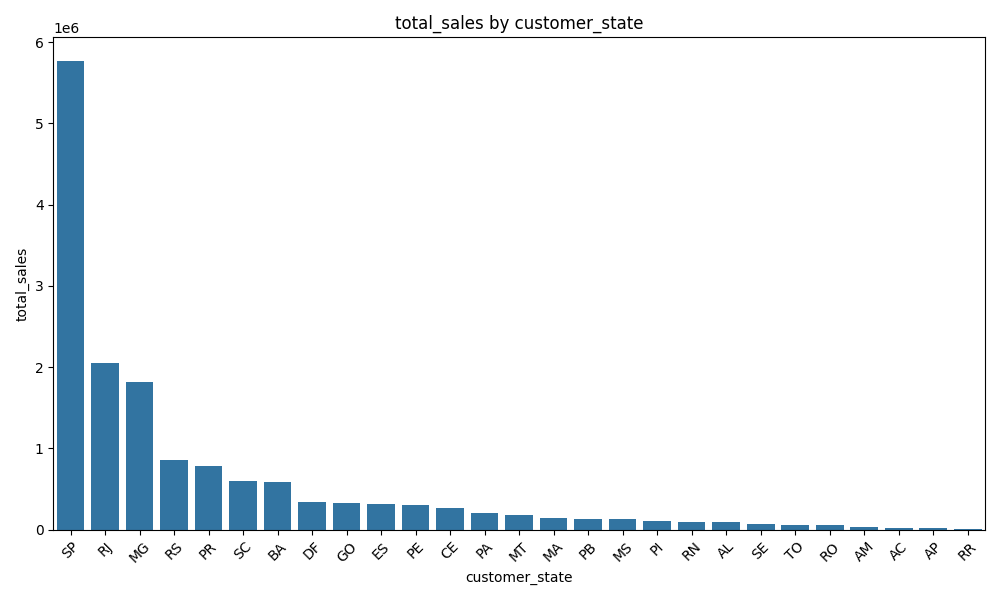


Displaying category_performance visualization:


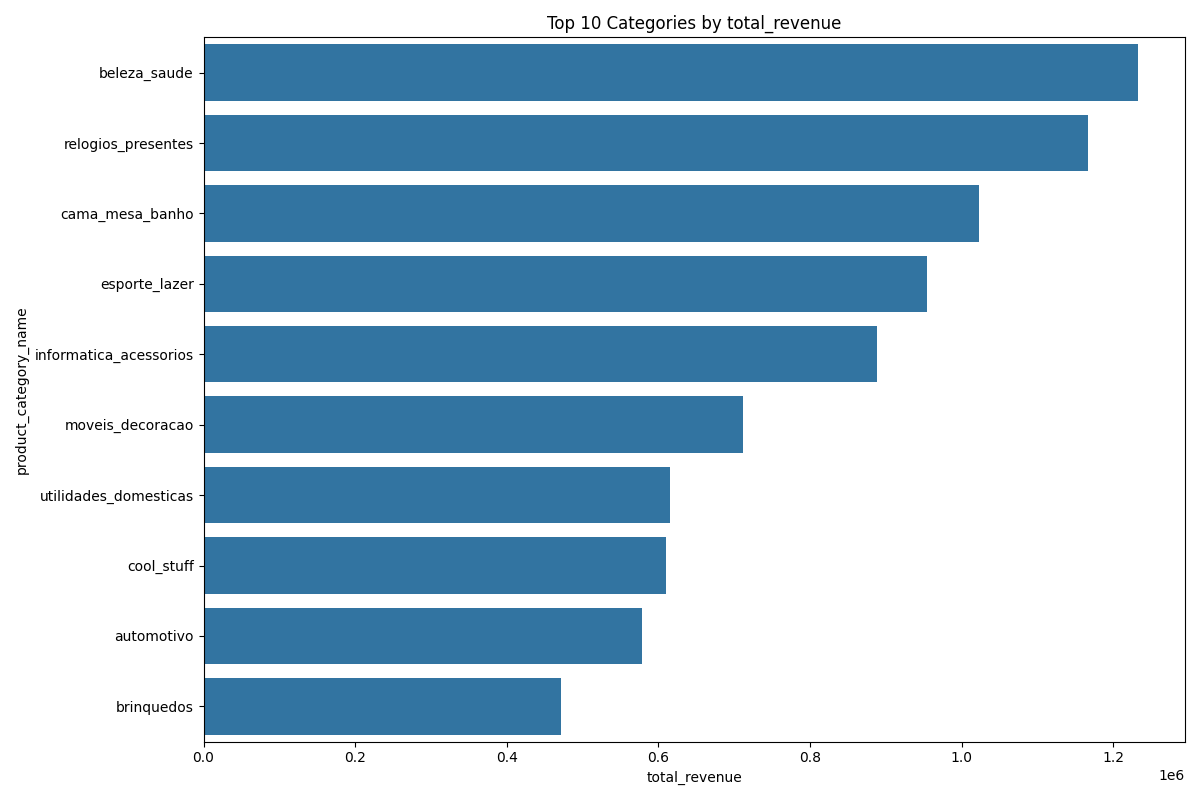


Displaying customer_lifetime_value visualization:


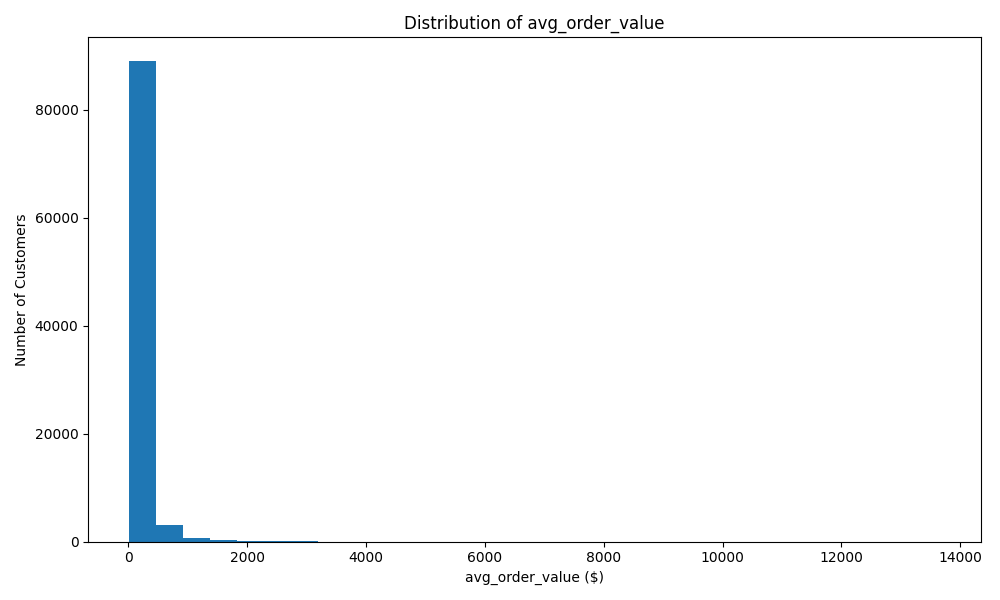

In [34]:
# Run the DAGs
run_acquisition_dag()
run_kpi_dag()

In [ ]:
!mkdir -p brazilian-ecommerce-etl/dags
!mkdir -p brazilian-ecommerce-etl/data

**CSV files of Stored KPIs**

In [35]:
#KPI Sales_by_region
df=pd.read_csv(r"/content/data/sales_by_region.csv")
df.head()

,customer_state,num_orders,total_sales
0,SP,42308,5770266.19
1,RJ,13004,2055690.45
2,MG,11804,1819277.61
3,RS,5544,861802.40
4,PR,5129,781919.55


In [38]:
df1=pd.read_csv(r"/content/data/CLV.csv")
df1.head()

,customer_state,num_orders,total_sales
0,SP,42308,5770266.19
1,RJ,13004,2055690.45
2,MG,11804,1819277.61
3,RS,5544,861802.40
4,PR,5129,781919.55


In [39]:
df2=pd.read_csv(r"/content/data/product_c_p.csv")
df2.head()

,customer_state,num_orders,total_sales
0,SP,42308,5770266.19
1,RJ,13004,2055690.45
2,MG,11804,1819277.61
3,RS,5544,861802.40
4,PR,5129,781919.55
